In [2]:
import numpy as np

# Declarando constantes

In [46]:
h = 0.003333333
k = 0.001
Db = 0.0001
Dn = 0.0001
phi = 0.2
ksi = 0.0
cb = 0.154
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
x_dom = (0,1)
y_dom = (0,1)
t_dom = (0,1)

In [47]:
def fb(Cb, Cn):
    return (cb - lambd_nb * Cn) * Cb


def fn(Cb, Cn, Cn_max):
    return y_n * Cb * (Cn_max - Cn) - lambd_bn * Cn * Cb - mi_n * Cn


def phix(Cbipj, Cbimj, Cbij, i, j, tam_max):
    ax = (Cbipj - Cbimj) / (2 * h)

    if (i == 0 or i == tam_max - 1) or (j == 0 or j == tam_max - 1) or (ax == 0):
        return 0

    elif ax > 0:
        return (ax * k / h) * (Cbij - Cbimj)

    elif ax < 0:
        return (ax * k / h) * (Cbipj - Cbij)


def phiy(Cbijp, Cbijm, Cbij, i, j, tam_max):
    ax = (Cbijp - Cbijm) / (2 * h)

    if (i == 0 or i == tam_max - 1) or (j == 0 or j == tam_max - 1) or (ax == 0):
        return 0

    elif ax > 0:
        return (ax * k / h) * (Cbij - Cbijm)

    elif ax < 0:
        return (ax * k / h) * (Cbijp - Cbij)


def apply_initial_conditions(Cb, tam_max):
    for i in range(tam_max):
        for j in range(tam_max):
            if (i * h >= 0.92) and (i * h) <= 1.0:
                if (j * h >= 0.92) and (j * h) <= 1.0:
                    Cb[i][j] = 0.001

    return Cb


def solve_pde():
    size_x = int(((x_dom[1] - x_dom[0]) / (h)) + 1)
    size_y = int(((y_dom[1] - y_dom[0]) / (h)) + 1)
    size_tt = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    x = np.linspace(x_dom[0], x_dom[1], num=size_x, endpoint=True)
    y = np.linspace(y_dom[0], y_dom[1], num=size_y, endpoint=True)
    t = np.linspace(t_dom[0], t_dom[1], num=size_tt, endpoint=True)

    print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

    Cn_old = np.zeros((size_x, size_y))
    Cn_new = np.zeros((size_x, size_y))

    Cb_old = np.zeros((size_x, size_y))
    Cb_new = np.zeros((size_x, size_y))

    print(
        "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
            size_tt,
            size_x,
            size_y,
        )
    )

    Cb_old = apply_initial_conditions(Cb_old, size_x)

    u_a = u_b = u_c = u_d = 0

    r_n = (Dn * k) / (phi * (h * h))
    r_b = (Db * k) / (phi * (h * h))

    for time in range(size_tt):
        for i in range(size_x):
            for j in range(size_y):
                # Tratando Cb
                if j == size_y - 1:
                    Cb_uijp = 2 * h * u_c + Cb_old[i][size_y - 1]

                else:
                    Cb_uijp = Cb_old[i][j + 1]
                if j == 0:
                    Cb_uijm = 2 * h * u_a + Cb_old[i][1]

                else:
                    Cb_uijm = Cb_old[i][j - 1]

                if i == size_x - 1:
                    Cb_uipj = 2 * h * u_d + Cb_old[size_x - 1][j]
                else:
                    Cb_uipj = Cb_old[i + 1][j]
                if i == 0:
                    Cb_uimj = 2 * h * u_b * Cb_old[1][j]
                else:
                    Cb_uimj = Cb_old[i - 1][j]

                # Tratando Cn
                if j == size_y - 1:
                    Cn_uijp = 2 * h * u_c + Cn_old[i][size_y - 1]
                else:
                    Cn_uijp = Cn_old[i][j + 1]
                #
                if j == 0:
                    Cn_uijm = 2 * h * u_a + Cn_old[i][1]
                else:
                    Cn_uijm = Cn_old[i][j - 1]
                #
                if i == size_x - 1:
                    Cn_uipj = 2 * h * u_d + Cn_old[size_x - 1][j]
                else:
                    Cn_uipj = Cn_old[i + 1][j]
                #
                if i == 0:
                    Cn_uimj = 2 * h * u_b * Cn_old[1][j]
                else:
                    Cn_uimj = Cn_old[i - 1][j]

                Cb_new[i][j] = (
                    r_b * (Cb_uimj + Cb_uipj - 4 * Cb_old[i][j] + Cb_uijp + Cb_uijm)
                    + (k / phi) * (fb(Cb_old[i][j], Cn_old[i][j]))
                    + Cb_old[i][j]
                )

                Cn_new[i][j] = (
                    r_n * (Cn_uimj + Cn_uipj - 4 * Cn_old[i][j] + Cn_uijp + Cn_uijm)
                    + (k / phi) * (fn(Cb_old[i][j], Cn_old[i][j], 0.55))
                    + Cn_old[i][j]
                    + ksi
                    * (
                        -phix(Cb_uipj, Cb_uimj, Cb_old[i][j], i, j, size_x)
                        - phiy(Cb_uijp, Cb_uijm, Cb_old[i][j], i, j, size_y)
                    )
                )

        for i in range(size_x):
            for j in range(size_y):
                Cb_old[i][j] = Cb_new[i][j]
                Cn_old[i][j] = Cn_new[i][j]


    return x,y,t,Cb_new

In [48]:
x,y,t,Cb = solve_pde()

Size x = 301, y = 301 
 
Steps in time = 1001
Steps in space_x = 301
Steps in space_y = 301



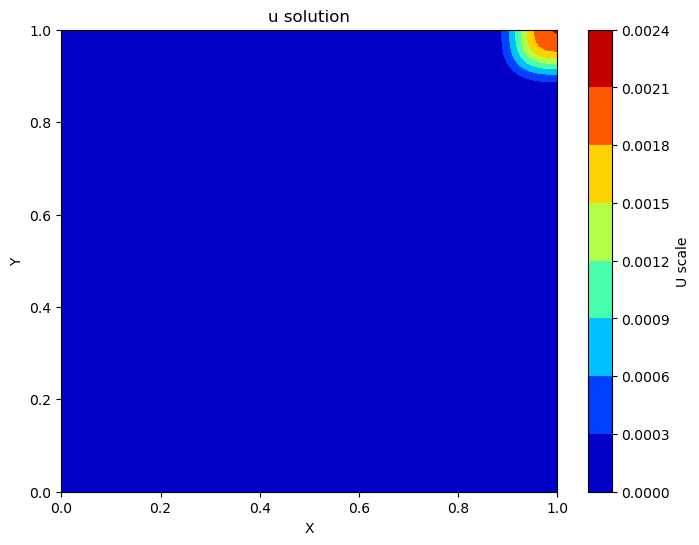

In [49]:
import matplotlib.pyplot as plt

X, Y = np.meshgrid(x, y)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Cb, cmap="jet")
plt.title("u solution")
plt.xlabel("X")
plt.ylabel("Y")
colobar = plt.colorbar(contour)
colobar.set_label("U scale")